# Healthcare Analysis Based on Demographics!

The goal is to examine how patient demographics (e.g. Age, Gender, Marital Status) influence treatment and healthcare access, identifying disparities in the quality of care. 

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Disparities in Healthcare Analysis").getOrCreate()
from pyspark.sql.functions import year, current_date, concat_ws, when, col, trim, lower,count, mean, stddev, to_timestamp, unix_timestamp, regexp_replace, sum
import boto3
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Initial setting up Data Frames and Exploration

We have already completed the ETL portion of extracting the data from individual patient json files. The extraction was done based on categories such as observation, immunization, diagnostic  reports, enocounters, claims data etc. That data is stored in parquet format for each category and is being used here below to examine what each dataframe looks like at the moment.    

In [ ]:
import sys

input = sys.argv[1]
s3 = boto3.client("s3")
bucket = sys.argv[2]
base_key = sys.argv[3]
#input = "etl"

observation_df = spark.read.parquet(f"{input}/observation")
immunization_df = spark.read.parquet(f"{input}/immunization")
diagnostic_report_df = spark.read.parquet(f"{input}/diagnostic_report")
procedure_df = spark.read.parquet(f"{input}/procedure")
careteam_df = spark.read.parquet(f"{input}/careteam")
careplan_df = spark.read.parquet(f"{input}/careplan")
explanation_of_benefit_df = spark.read.parquet(f"{input}/explanation_of_benefit")
claim_df = spark.read.parquet(f"{input}/claim")
medication_request_df = spark.read.parquet(f"{input}/medication_request")
condition_df = spark.read.parquet(f"{input}/condition")
encounter_df = spark.read.parquet(f"{input}/encounter")
patient_df = spark.read.parquet(f"{input}/patient")


#observation_df.show(5)
# immunization_df.show(5)
# diagnostic_report_df.show(5)
# procedure_df.show(5)
# careteam_df.show(5)
# careplan_df.show(5)
# explanation_of_benefit_df.show(5)
# claim_df.show(5)
# medication_request_df.show(5)
# condition_df.show(5)
# encounter_df.show(5)



We looked at all the dataframes and the one's that interest us the most are the patients, encounters and the explanation of benefit dataframe. We are going to start with the patient data frame as it contains the key variables on which the project is going to focus. 

In [ ]:
patient_df.show(5)
patient_df.printSchema()

In [ ]:
cities_count = patient_df.select("city").distinct().count()
print(f"Number of cities: {cities_count}")
patient_df.select("city").distinct().show()
patient_df.select("state").distinct().show()

patient_df.select("languages").show()
patient_df.select("marital_status").distinct().show()
patient_df.select("gender").distinct().show()

After the initial exploration, the primary areas to focus on are Gender, Marital Status and Age. We expected to have socioeconomic and ethnic data in the demographics, but they were not present in the dataset. Age is calculated based on the birth year and the current date. We drop the columns that are not needed and store them in a new dataframe that is called patient_df_cleaned. 

In [ ]:
patient_df_cleaned = patient_df.select(
    "patient_id",
    "gender",
    "birth_date",
    "state",
    "postal_code",
    "marital_status",
    "disability_adjusted_life_years",
    "quality_adjusted_life_years",
)

### Calculating age

In [ ]:
patient_df_cleaned = patient_df_cleaned.withColumn(
    "age",
    year(current_date()) - year(col("birth_date"))
)

patient_df_cleaned.show()

### Standardizing Marital Status 

In [ ]:

patient_df_cleaned = patient_df_cleaned.withColumn(
    "marital_status",
    trim(lower(col("marital_status")))  
)

patient_df_cleaned = patient_df_cleaned.withColumn(
    "marital_status",
    when(col("marital_status") == "m", "Married")
    .when(col("marital_status") == "s", "Single")
    .when(col("marital_status") == "never married", "Never Married")
    .otherwise("Unknown")  
)

patient_df_cleaned.select("marital_status").distinct().show()

Making sure there are no patients without a patient ID

In [ ]:
null_patient_id = patient_df_cleaned.filter(col("patient_id").isNull()).count()

print(f"null 'patient_id': {null_patient_id}")

### Observations from the Patient dataset. 

We look at the distribution of patients by gender. We calculate the average age of patients and the std deviation between them. Then we look at the marital status of the patients. 

In [ ]:
patient_df_cleaned.groupBy("gender").agg(count("*").alias("count")).show()

In [ ]:
age_stats = patient_df_cleaned.select(
    mean("age").alias("average_age"),
    stddev("age").alias("stddev_age")
)
age_stats.show()

In [ ]:
patient_df_cleaned.groupBy("marital_status").agg(count("*").alias("count")).show()

In [ ]:
patient_df_cleaned.groupBy("gender", "marital_status").agg(
    mean("age").alias("average_age"),
    stddev("age").alias("stddev_age"),
    count("*").alias("count")
).show(truncate=False)

Uploading plots to S3 function

In [ ]:
def upload_plot_to_s3(plt, plot_name):
    
    buffer = io.BytesIO()
    plt.savefig(buffer, format="png")
    buffer.seek(0)  
    
    key = f"{base_key}/{plot_name}.png"
    
    s3.put_object(Bucket=bucket, Key=key, Body=buffer, ContentType="image/png")
    
    buffer.close()
    
    print(f"Plot successfully uploaded to s3://{bucket}/{key}")

In [ ]:
gender_counts = patient_df_cleaned.groupBy("gender").count().toPandas()
age_counts = patient_df_cleaned.groupBy("age").count().toPandas()
marital_status_counts = patient_df_cleaned.groupBy("marital_status").count().toPandas()
age_by_gender_marital_status = patient_df_cleaned.groupBy("gender", "marital_status").agg(
    mean("age").alias("average_age"),
    stddev("age").alias("stddev_age"),
    count("*").alias("count")
).toPandas()

#### Gender Distribution Bar Plot

In [ ]:

plt.figure(figsize=(8, 6))
sns.barplot(data=gender_counts, x="gender", y="count", palette="Set2")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
upload_plot_to_s3(plt, "gender_distribution")

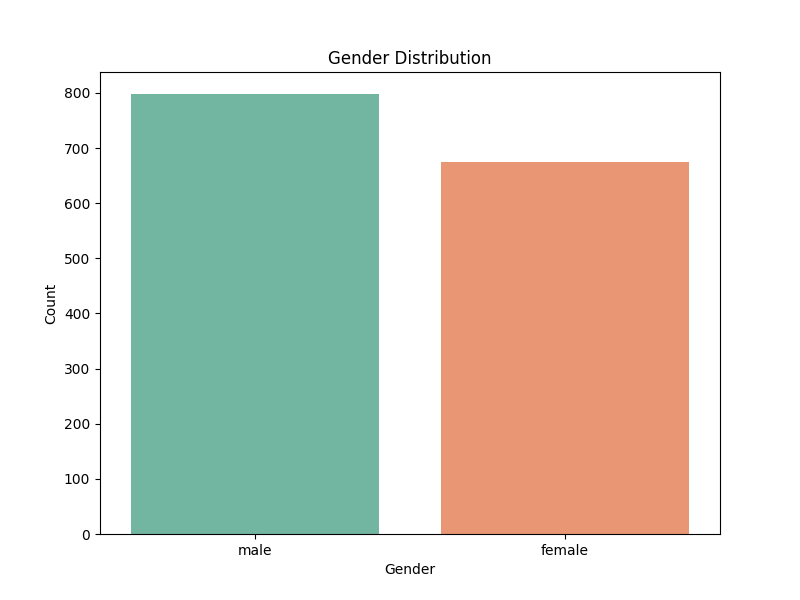

#### Age Distribution (Box Plot)

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="age", data=age_counts, color="lightblue")
plt.title("Age Distribution")
plt.xlabel("Age")
upload_plot_to_s3(plt, "age_distribution_boxplot")

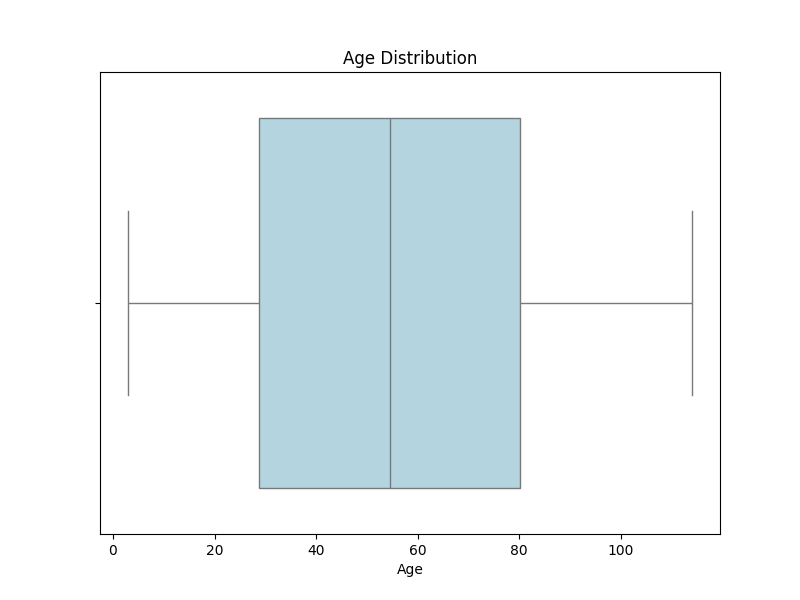

#### Marital Status Distribution Bar Plot

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=marital_status_counts, x="marital_status", y="count", palette="muted")
plt.title("Marital Status Distribution")
plt.xlabel("Marital Status")
plt.ylabel("Count")
upload_plot_to_s3(plt, "marital_status_distribution")

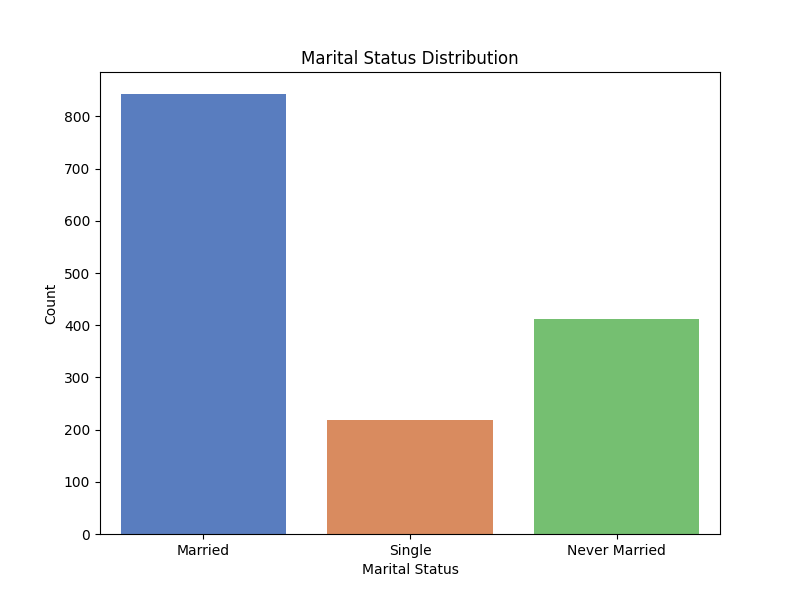

#### Average Age by Gender and Marital Status

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=age_by_gender_marital_status, x="gender", y="average_age", hue="marital_status")
plt.title("Average Age by Gender and Marital Status")
plt.xlabel("Gender")
plt.ylabel("Average Age")
upload_plot_to_s3(plt, "average_age_by_gender_marital_status")

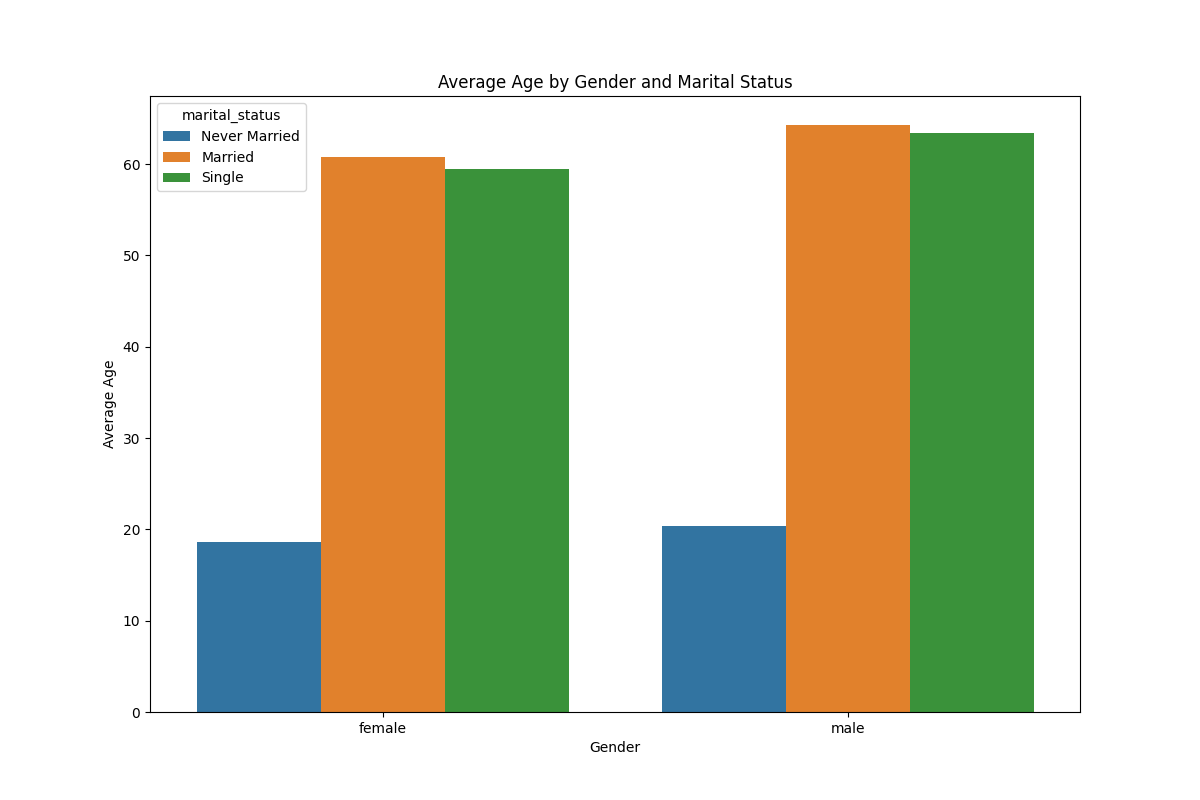

# Encounters 

After examining the patient df and demographics, now we want to see what kind of healtchare access usually patients get. We start by examining and cleaning the df encounters.


In [ ]:
encounter_df.printSchema()
encounter_df.show(10, truncate=False)

We look at differennt HL7 class codes and then standardize them based on the information we got from https://terminology.hl7.org/1.0.0/ValueSet-v3-ActEncounterCode.html 

In [ ]:
encounter_df.select("class_code").distinct().show(truncate=False)

In [ ]:
encounter_df.select("status").distinct().show(truncate=False)

We create an cleaned encounter df and convert the timestamps from strings so that we can calculate the enocunter duration for each encounter 

In [ ]:
encounter_df_cleaned = encounter_df
encounter_df_cleaned = encounter_df.dropna(subset=["encounter_id", "patient_reference", "start_time"])
encounter_df_cleaned = encounter_df_cleaned.withColumn("start_time", to_timestamp("start_time"))
encounter_df_cleaned = encounter_df_cleaned.withColumn("end_time", to_timestamp("end_time"))
encounter_df_cleaned = encounter_df_cleaned.withColumn(
    "encounter_duration",
    (unix_timestamp("end_time") - unix_timestamp("start_time")) / 60  
)

In [ ]:
encounter_df_cleaned = encounter_df_cleaned.withColumn(
    "status",
    when(col("status") == "finished", "Completed")
    .otherwise("In-Progress")
)

In [ ]:
encounter_df_cleaned.select("status").distinct().show() #Probably going to drop if only finished values

In [ ]:
encounter_df_cleaned = encounter_df_cleaned.withColumn(
    "class_code",
    when(col("class_code") == "IMP", "Inpatient")
    .when(col("class_code") == "AMB", "Ambulatory")
    .when(col("class_code") == "EMER", "Emergency")
    .otherwise("Unknown")  
)

encounter_df_cleaned.select("class_code").distinct().show()

The patient_reference is not in correct format so we have to strip the initial terms from it to match it with patient id's in patient df.

In [ ]:
encounter_df_cleaned = encounter_df_cleaned.withColumn(
    "patient_reference",
    regexp_replace("patient_reference", "urn:uuid:", "")
)

encounter_df_cleaned.select("patient_reference").distinct().show(truncate=False)
encounter_df_cleaned.show(10, truncate=False)

In [ ]:
encounter_df_cleaned.select("patient_reference").distinct().count()
encounter_df_cleaned.select("patient_reference").distinct().show(truncate=False)

We join the cleaned encounter df with cleaned patient df.

In [ ]:
encounter_patient_df = encounter_df_cleaned.join(
    patient_df_cleaned,
    encounter_df_cleaned.patient_reference == patient_df_cleaned.patient_id,
    how="inner"
)

In [ ]:
encounter_patient_df.printSchema()
encounter_patient_df.show(10, truncate=False)

Dropping the unnecessary columns from the encounter_patient_df

In [ ]:
encounter_patient_df = encounter_patient_df.drop(
    "service_provider_id",
    "service_provider_display",
    "participant_individual_display",
    "participant_individual_reference",
    "participant_period_start",
    "participant_period_end",
    "participant_type_code",
    "participant_type_display"
)

In [ ]:
overlap_count = encounter_df_cleaned.join(
    patient_df_cleaned,
    encounter_df_cleaned.patient_reference == patient_df_cleaned.patient_id,
    how="inner"
).count()
print(f"Number of overlapping records: {overlap_count}")

In [ ]:
encounter_patient_df.groupBy("gender", "class_code").count().show()

#### Gender vs Class Code Count

In [ ]:
gender_class_code_counts = encounter_patient_df.groupBy("gender", "class_code").count().toPandas()

pivot_data = gender_class_code_counts.pivot(index="gender", columns="class_code", values="count").fillna(0)


pivot_data.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2")
plt.title("Gender vs Class Code Encounter Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Class Code")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "Gender_vs_Class_Code_Count")

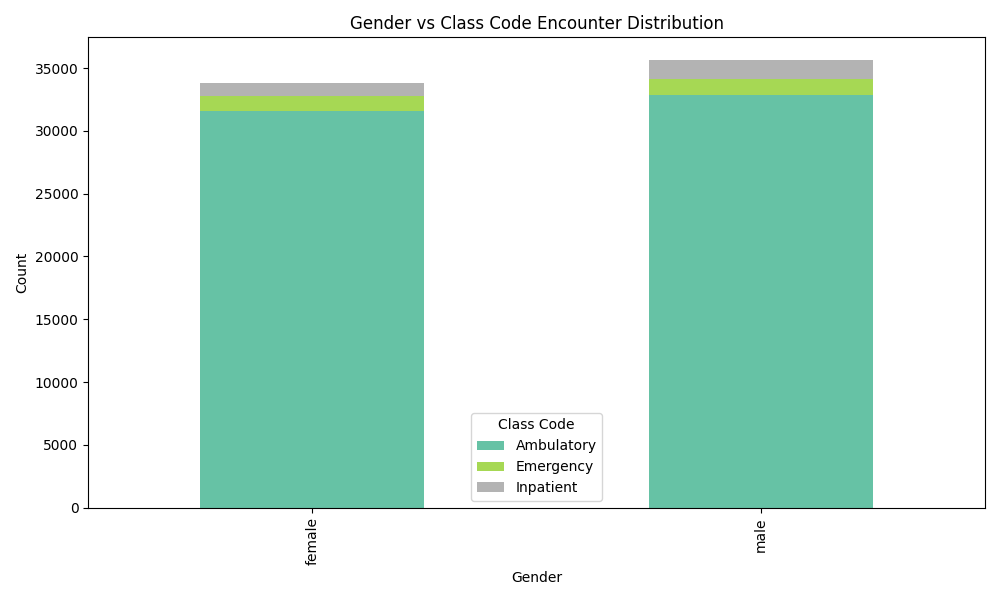

In [ ]:
encounter_patient_df.groupBy("gender").agg(mean("encounter_duration").alias("avg_duration")).show()

#### Gender vs Average Encounter Duration Plot

In [ ]:
gender_avg_duration = encounter_patient_df.groupBy("gender").agg(mean("encounter_duration").alias("avg_duration")).toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=gender_avg_duration, x="gender", y="avg_duration", palette="Set2")
plt.title("Average Encounter Duration by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Duration")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "Gender_vs_Avg_Encounter_Duration")

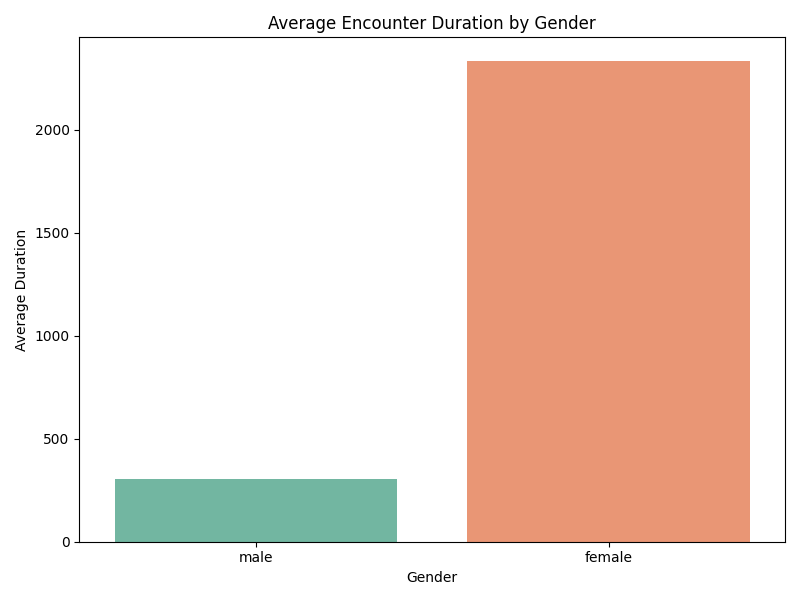

Creating Age groups to use ages as a classifier in our analysis 

In [ ]:
from pyspark.sql.functions import when

encounter_patient_df = encounter_patient_df.withColumn(
    "age_group",
    when(col("age") < 18, "Child")
    .when((col("age") >= 18) & (col("age") < 40), "Young Adult")
    .when((col("age") >= 40) & (col("age") < 65), "Middle Aged")
    .otherwise("Senior")
)

encounter_patient_df.groupBy("age_group").agg(mean("encounter_duration").alias("avg_duration")).show()


#### Age Group vs Average Encounter Duration Plot

In [ ]:
age_group_avg_duration = encounter_patient_df.groupBy("age_group").agg(mean("encounter_duration").alias("avg_duration")).toPandas()

plt.figure(figsize=(8, 6))
sns.lineplot(data=age_group_avg_duration, x="age_group", y="avg_duration", marker="o", palette="Set2")
plt.title("Average Encounter Duration by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Duration")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "AgeGroup_vs_Average_Encounter_Duration")


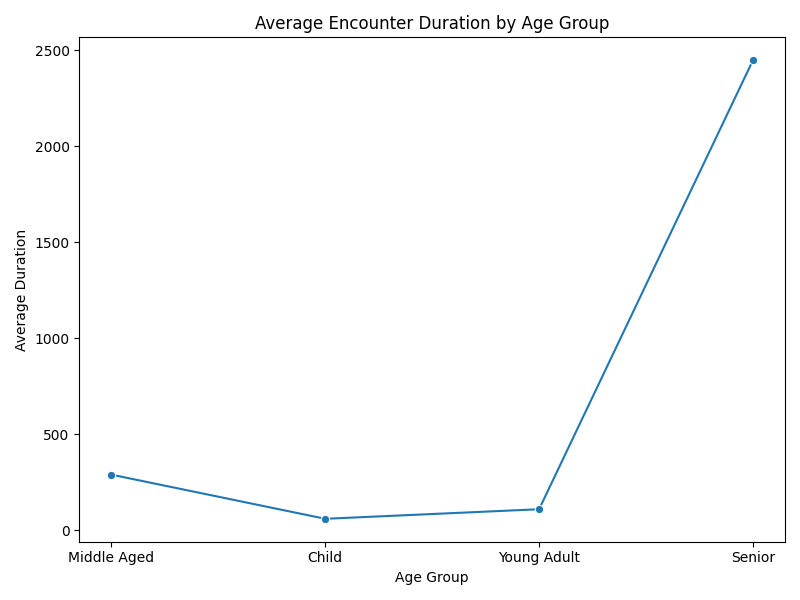

In [ ]:
encounter_patient_df.orderBy(col("encounter_duration").desc()).show(10, truncate=False)


Some patients may be in the hospital for a significant long period of time, we are trying to remove these outliers from our dataset. 

In [ ]:

inpatient_long_stay = encounter_patient_df.filter((col("class_code") == "Inpatient") & (col("encounter_duration") > 1440))


inpatient_long_stay.orderBy(col("encounter_duration").desc()).show(10, truncate=False)


Finding out avg and max duration of different types of encounters 

In [ ]:

from pyspark.sql.functions import max

encounter_patient_df.groupBy("class_code").agg(
    mean("encounter_duration").alias("avg_duration"),
    max("encounter_duration").alias("max_duration")
).show()



In [ ]:
filtered_encounter_patient_df = encounter_patient_df.filter(
    (col("encounter_duration") <= 86400) | (col("class_code") != "Inpatient")
)

filtered_encounter_patient_df.show(10, truncate=False)

#86400 is equal to 60 days in the hospital 

Creating a seperate df for outliers

In [ ]:
outliers_df = encounter_patient_df.filter(col("encounter_duration") > 86400)
outliers_df.show()

In [ ]:
filtered_encounter_patient_df.groupBy("class_code").agg(
    mean("encounter_duration").alias("avg_duration")
).show()


#### Class Code vs Average Encounter Duration with Filtered Data Plot

In [ ]:
class_code_duration_stats = filtered_encounter_patient_df.groupBy("class_code").agg(
    mean("encounter_duration").alias("avg_duration"),
    max("encounter_duration").alias("max_duration")
).toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=class_code_duration_stats, x="avg_duration", y="max_duration", hue="class_code", palette="Set2", s=100)
plt.title("Average vs Max Encounter Duration by Class Code")
plt.xlabel("Average Duration")
plt.ylabel("Max Duration")
plt.legend(title="Class Code")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "Class_Code_vs_Average_Encounter_Duration_with_Filtered_Data")

In [ ]:
# Group by age_group and class_code with filtered data
filtered_encounter_patient_df.groupBy("class_code", "age_group").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("class_code", "age_group").show()


#### Heatmap for Class Code, Age Group vs Average Encounter Duration

In [ ]:
class_code_age_group_avg_duration = filtered_encounter_patient_df.groupBy("class_code", "age_group").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("class_code", "age_group").toPandas()

pivot_data = class_code_age_group_avg_duration.pivot(
    index="class_code",  
    columns="age_group",  
    values="avg_duration"  
).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Average Encounter Duration by Class Code and Age Group (Heatmap)")
plt.xlabel("Age Group")
plt.ylabel("Class Code")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "Heatmap_for_Class_Code_Age_Group_Average_Encounter")

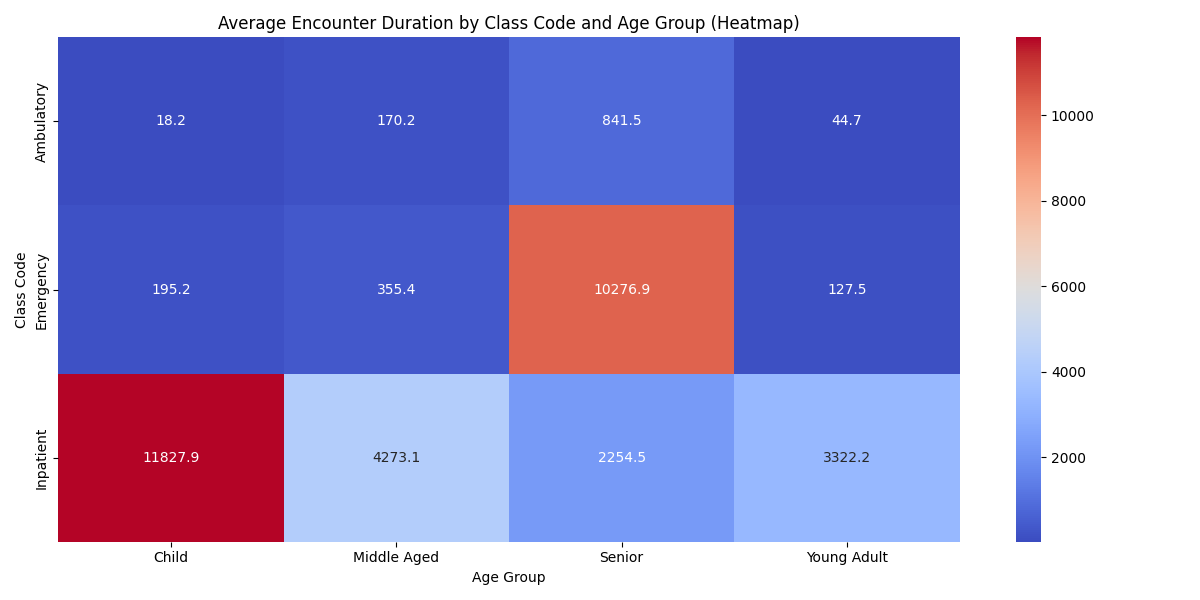

In [ ]:
# Group by class_code, age_group, and gender to calculate average duration
filtered_encounter_patient_df.groupBy("class_code", "age_group", "gender").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("class_code", "age_group", "gender").show(truncate=False)


#### Heatmap for Class Code, Age Group, Gender vs Average Encounter Duration

In [ ]:
class_code_age_group_gender_avg_duration = filtered_encounter_patient_df.groupBy("class_code", "age_group", "gender").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("class_code", "age_group", "gender").toPandas()

pivot_data = class_code_age_group_gender_avg_duration.pivot_table(index=["class_code", "age_group"], columns="gender", values="avg_duration").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Average Encounter Duration by Class Code, Age Group, and Gender (Heatmap)")
plt.xlabel("Gender")
plt.ylabel("Class Code and Age Group")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "Heatmap_for_Class_Code_Age_Group_Gender_Average_Encounter")

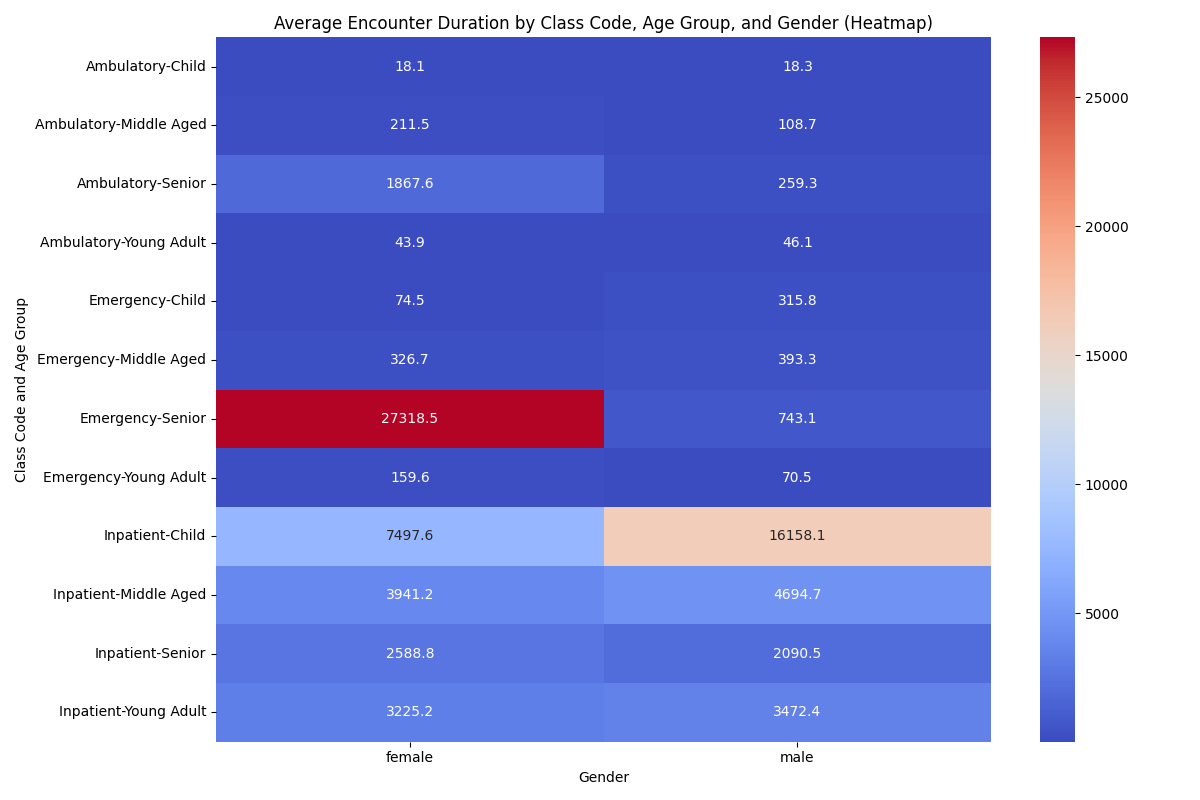

In [ ]:
filtered_encounter_patient_df.groupBy("marital_status").agg(
    mean("encounter_duration").alias("avg_duration")
).show()

In [ ]:
filtered_encounter_patient_df.groupBy("marital_status", "gender").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("marital_status", "gender").show()

#### Marital Status vs Gender vs Average Encounter Duration

In [ ]:
marital_gender_avg_duration = filtered_encounter_patient_df.groupBy("marital_status", "gender").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("marital_status", "gender").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=marital_gender_avg_duration, x="marital_status", y="avg_duration", hue="gender", palette="Set2")
plt.title("Average Encounter Duration by Marital Status and Gender")
plt.xlabel("Marital Status")
plt.ylabel("Average Duration")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "MaritalStatusvsGendervsAverageEncounter")


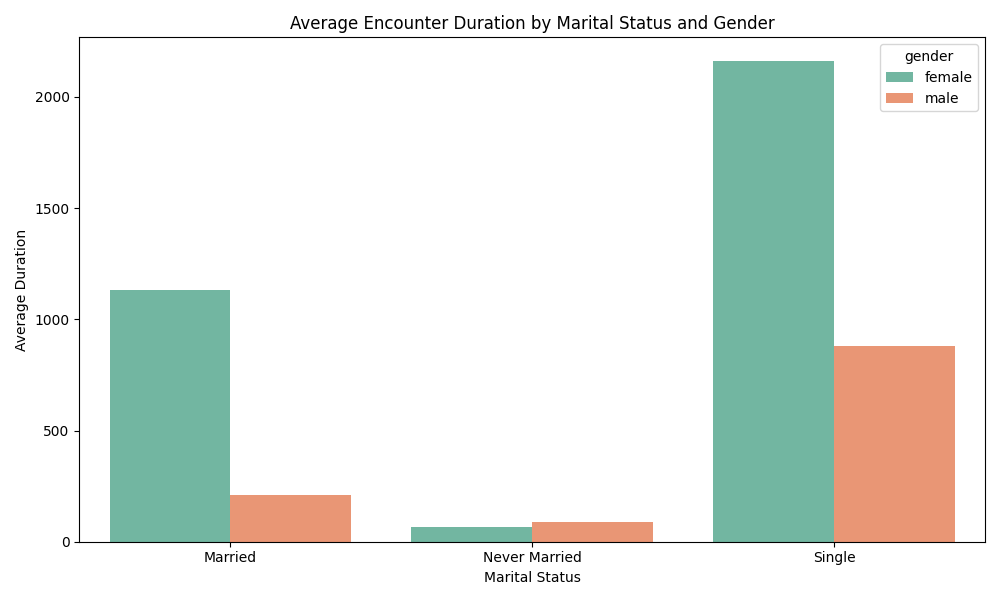

In [ ]:
filtered_encounter_patient_df.groupBy("marital_status", "gender", "age_group").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("marital_status", "gender", "age_group").show(truncate=False)

#### Marital Status, Gender, Age Group vs Average Encounter Duration

In [ ]:
marital_gender_age_avg_duration = filtered_encounter_patient_df.groupBy("marital_status", "gender", "age_group").agg(
    mean("encounter_duration").alias("avg_duration")
).orderBy("marital_status", "gender", "age_group").toPandas()

sns.set(style="whitegrid")
g = sns.catplot(
    data=marital_gender_age_avg_duration, 
    x="marital_status", 
    y="avg_duration", 
    hue="gender", 
    col="age_group",  
    kind="bar", 
    height=6, 
    aspect=1.2, 
    palette="Set2"
)
g.set_axis_labels("Marital Status", "Average Encounter Duration")
g.set_titles("Age Group: {col_name}")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "MaritalStatusGenderAgeGroupvsAverageEncounterDuration")

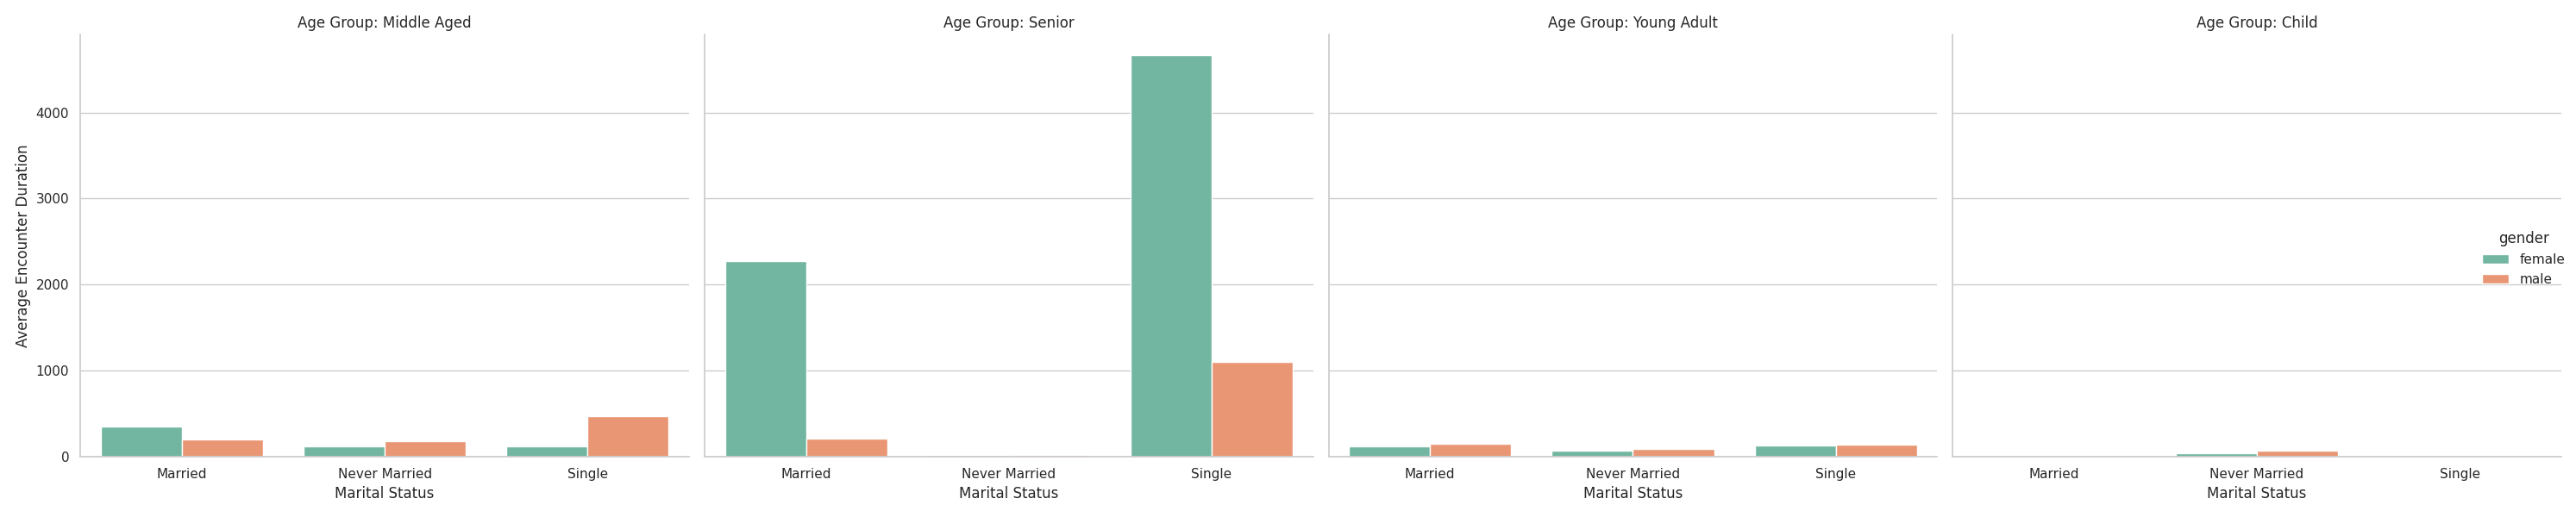

# Explanation of Benefits (Claims)

Explanation of benefits is the most important df since it contains and links claims, encounters and patient demographics. We can find out how much someone spent on their encounters. So we start by examining Explanation of benefits data frame, trying to clean and extract the payment information for encounters.

In [ ]:
explanation_of_benefit_df.printSchema()
explanation_of_benefit_df.show(10, truncate=False)


In [ ]:
explanation_of_benefit_df.select("eob_id").distinct().count()

We can see there are null values in columns because we might have nested data that we need to extract. 

In [ ]:
explanation_of_benefit_df.select(
    mean("total_amount").alias("avg_total_amount"),
    mean("payment_amount").alias("avg_payment_amount"),
    sum("total_amount").alias("total_claimed"),
    sum("payment_amount").alias("total_paid")
).show()

In [ ]:
# explanation_of_benefit_df.select(
#     sum(col("total_amount").isNull().cast("int")).alias("null_total_amount"),
#     sum(col("payment_amount").isNull().cast("int")).alias("null_payment_amount")
# ).show()


In [ ]:
explanation_of_benefit_df.select("total_amount", "payment_amount").show(truncate=False)

In [ ]:

explanation_of_benefit_df.filter(col("total_amount").isNotNull()).select("total_amount").show(truncate=False)


From the dataframe, adjudication is the column with many nested arrays that we need to extract values from since it contains all the co-pay, procedure amount. 

In [ ]:
explanation_of_benefit_df.select("adjudication").show(truncate=False)

In [ ]:

explanation_of_benefit_df.select("adjudication").printSchema()


We created another dataframe to store the flattened adjudicated df but we still have nested columns here so we might have to extract a few more items before we join it with the encounter and patient df. 

In [ ]:
from pyspark.sql.functions import explode

# Explode the adjudication array
adjudication_exploded_df = explanation_of_benefit_df.select(
    "eob_id",
    "patient_reference",
    explode("adjudication").alias("adjudication_item")
)


adjudication_exploded_df.show(truncate=False)


In [ ]:
# Extract amount and category fields
adjudication_details_df = adjudication_exploded_df.select(
    "eob_id",
    "patient_reference",
    "adjudication_item.amount.value",
    "adjudication_item.amount.currency",
    "adjudication_item.category.coding"
)


adjudication_details_df.show(truncate=False)


In [ ]:
adjudication_details_df.printSchema()

In [ ]:
# Extract the first element of the 'coding' array and its fields
adjudication_details_df = adjudication_details_df.withColumn(
    "category_code",
    col("coding").getItem(0).getField("code")  
).withColumn(
    "category_display",
    col("coding").getItem(0).getField("display")  
)


adjudication_details_df.select("category_code", "category_display").show(truncate=False)


We join our new extracted adjudicated columns df with the original adjudicated df  

In [ ]:
adjudication_with_claims_df = adjudication_details_df.join(
    explanation_of_benefit_df.select("eob_id", "insurance_coverage_display", "billable_period_start"),
    ["eob_id"],
    how="inner"
)

adjudication_with_claims_df.show(truncate=False)

In [ ]:
adjudication_with_claims_cleaned_df = adjudication_with_claims_df.drop("coding", "category_code", "insurance_coverage_display")
adjudication_with_claims_cleaned_df.show(truncate=False)
adjudication_with_claims_cleaned_df.printSchema()

Creating our cleaned and final df for claims also cleaning the patient reference so we can match that with the encounter_patient df.

In [ ]:
eob_final_df_cleaned = adjudication_with_claims_cleaned_df.withColumn(
    "patient_reference",
    regexp_replace("patient_reference", "urn:uuid:", "")
)

eob_final_df_cleaned.select("patient_reference").distinct().show(truncate=False)
eob_final_df_cleaned.show(10, truncate=False)

Joining this df with our patient and encounter df to get an explanation of benefits with demographics and encounter information

In [ ]:
eob_with_demographics_df = eob_final_df_cleaned.join(
    filtered_encounter_patient_df.select("patient_reference", "gender", "age", "marital_status", "age_group"),
    ["patient_reference"],
    how="inner"
)

eob_with_demographics_df.printSchema()
eob_with_demographics_df.show(truncate=False)


In [ ]:
eob_with_demographics_df.select("category_display").distinct().show(truncate=False)


Standardizing the categories 

In [ ]:
eob_with_demographics_df = eob_with_demographics_df.withColumn(
    "category_display_normalized",
    trim(lower(col("category_display")))
)

In [ ]:
eob_with_demographics_df.select("category_display", "category_display_normalized").distinct().show(truncate=False)

In [ ]:
eob_with_demographics_df = eob_with_demographics_df.withColumn(
    "category_display",
    trim(lower(col("category_display")))
)

eob_with_demographics_df = eob_with_demographics_df.withColumn(
    "category_display",
    when(col("category_display") == "line submitted charge amount", "Submitted Charge")
    .when(col("category_display") == "line beneficiary coinsurance amount", "Coinsurance Amount")
    .when(col("category_display") == "line allowed charge amount", "Allowed Charge")
    .when(col("category_display") == "line provider payment amount", "Provider Payment")
    .when(col("category_display") == "line beneficiary part b deductible amount", "Part B Deductible")
    .when(col("category_display") == "line processing indicator Code", "Processing Indicator")
    .otherwise("Unknown")  # if I have any unexpected values just in case
)

eob_with_demographics_df.select("category_display").distinct().show(truncate=False)

Removed the unknown and part b deductible from my categories since unknown categories have no values and part b deductible is always 0

In [ ]:
eob_with_demographics_filtered_df = eob_with_demographics_df.filter(
    (col("category_display") != "Unknown") & 
    (col("category_display") != "Part B Deductible")
)
eob_with_demographics_filtered_df.groupBy("category_display").agg(
    mean("value").alias("avg_value")
).show(truncate=False)

#### Average Value by Category

In [ ]:
category_display_avg_value = eob_with_demographics_filtered_df.groupBy("category_display").agg(
    mean("value").alias("avg_value")
).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=category_display_avg_value, x="category_display", y="avg_value", palette="Set2")
plt.title("Average Value by Category Display")
plt.xlabel("Category Display")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

upload_plot_to_s3(plt, "AverageValuebyCategory")

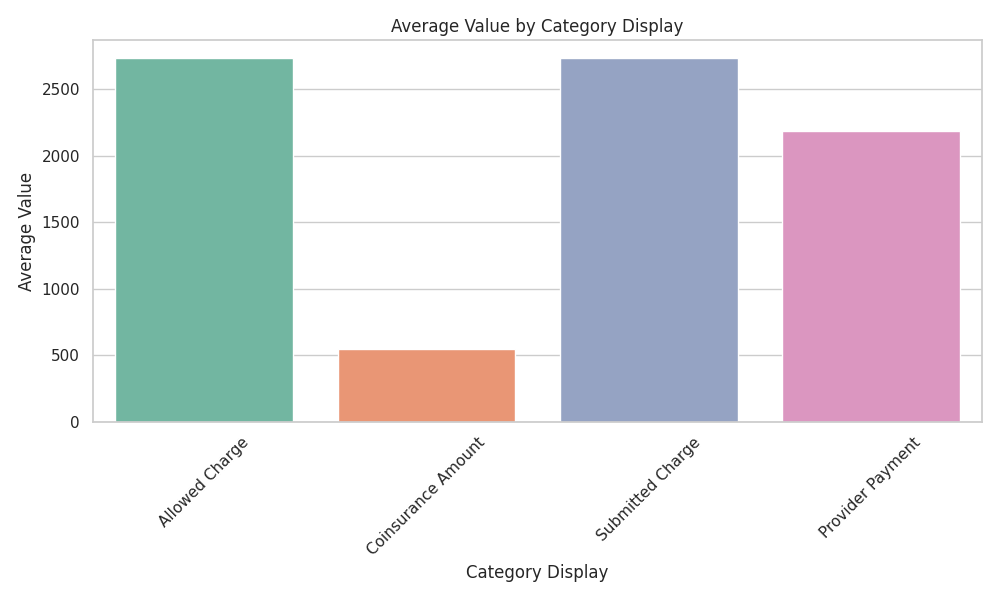

In [ ]:
eob_with_demographics_filtered_df.groupBy("category_display", "gender").agg(
    mean("value").alias("avg_value")
).orderBy("category_display", "gender").show(truncate=False)

#### Average Value by Category Display and Gender

In [ ]:
category_gender_avg_value = eob_with_demographics_filtered_df.groupBy("category_display", "gender").agg(
    mean("value").alias("avg_value")
).orderBy("category_display", "gender").toPandas()

plt.figure(figsize=(12, 8))
sns.catplot(data=category_gender_avg_value, x="category_display", y="avg_value", hue="gender", kind="bar", height=6, aspect=2)
plt.title("Average Value by Category Display and Gender")
plt.xlabel("Category Display")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "AverageValuebyCategoryDisplayandGender")

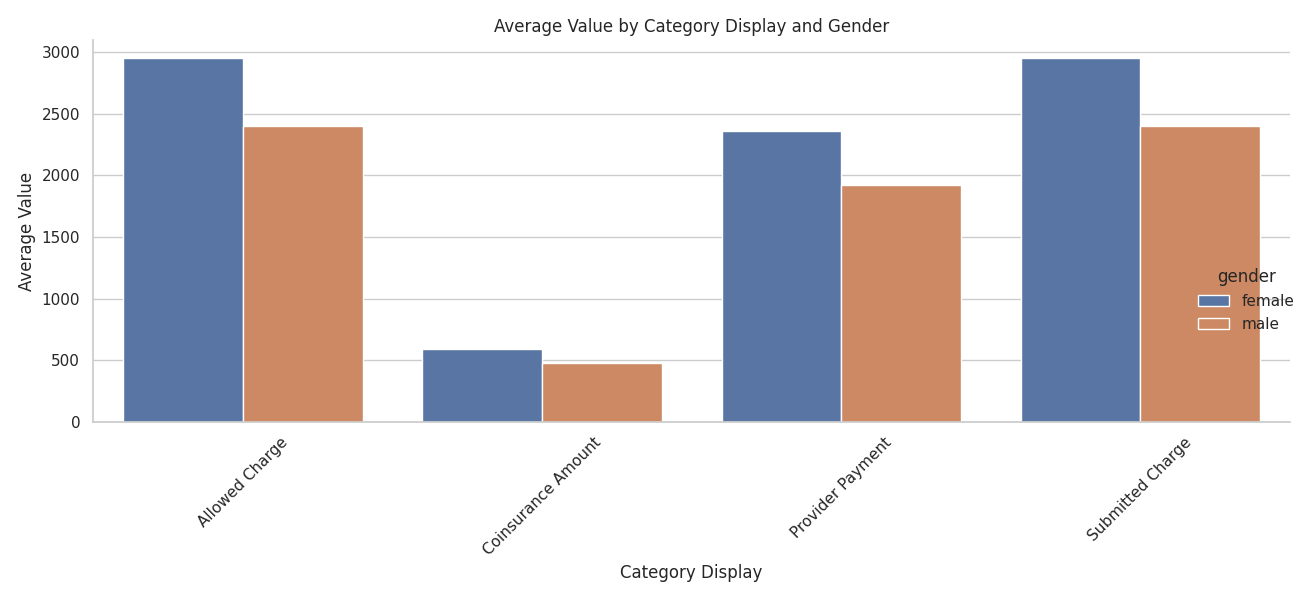

In [ ]:
eob_with_demographics_filtered_df.groupBy("category_display", "age_group").agg(
    mean("value").alias("avg_value")
).orderBy("category_display", "age_group").show(truncate=False)


#### Average Value by Category Display and Age Group

In [ ]:
plt.figure(figsize=(12, 8))
sns.catplot(data=category_age_group_avg_value, x="category_display", y="avg_value", hue="age_group", kind="bar", height=6, aspect=2)
plt.title("Average Value by Category Display and Age Group")
plt.xlabel("Category Display")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "AverageValuebyCategoryDisplayandAgeGroup")

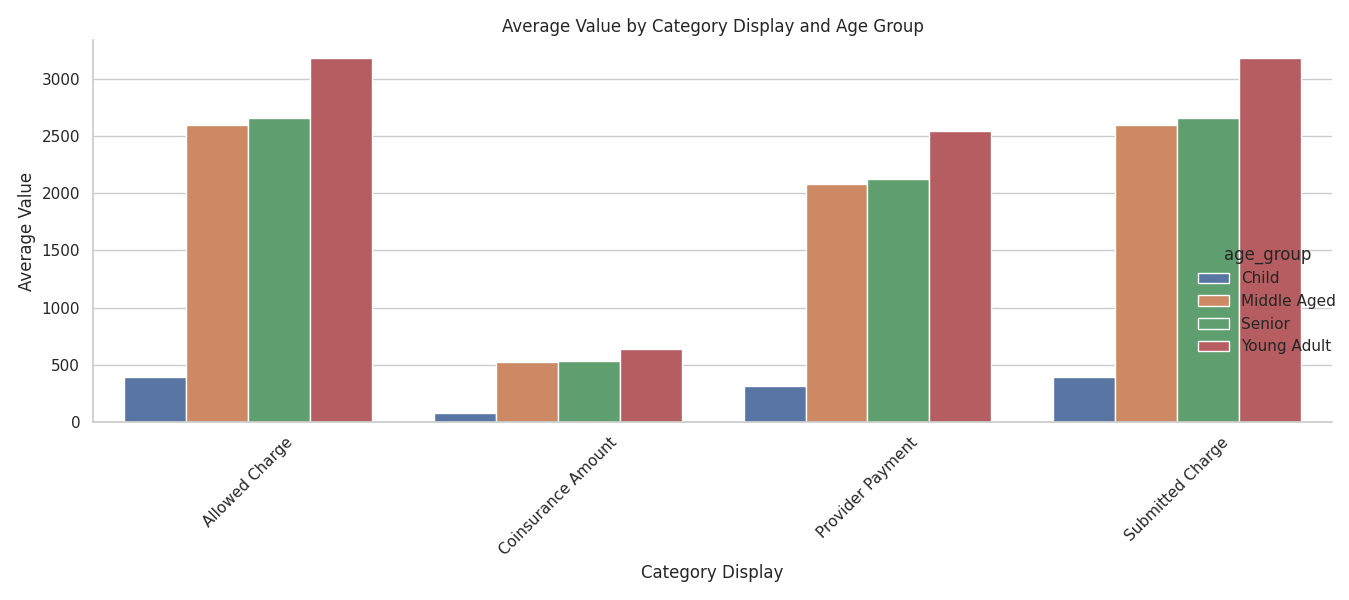

In [ ]:
eob_with_demographics_filtered_df.groupBy("category_display", "gender", "age_group", "marital_status").agg(
    mean("value").alias("avg_value")
).orderBy("category_display", "gender", "age_group", "marital_status").show(truncate=False)

category_gender_age_group_marital_avg_value = eob_with_demographics_filtered_df.groupBy(
    "category_display", "gender", "age_group", "marital_status"
).agg(
    mean("value").alias("avg_value")
).orderBy("category_display", "gender", "age_group", "marital_status").toPandas()


In [ ]:
plt.figure(figsize=(16, 12))
sns.catplot(
    data=category_gender_age_group_marital_avg_value, 
    x="category_display", 
    y="avg_value", 
    hue="gender", 
    col="age_group", 
    row="marital_status", 
    kind="bar", 
    height=5, 
    aspect=1.5
)
plt.suptitle("Average Value by Category Display, Gender, Age Group, and Marital Status", size=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  
plt.show()
upload_plot_to_s3(plt, "AverageValuebyCategoryDisplayandAgeGroupCatplot")

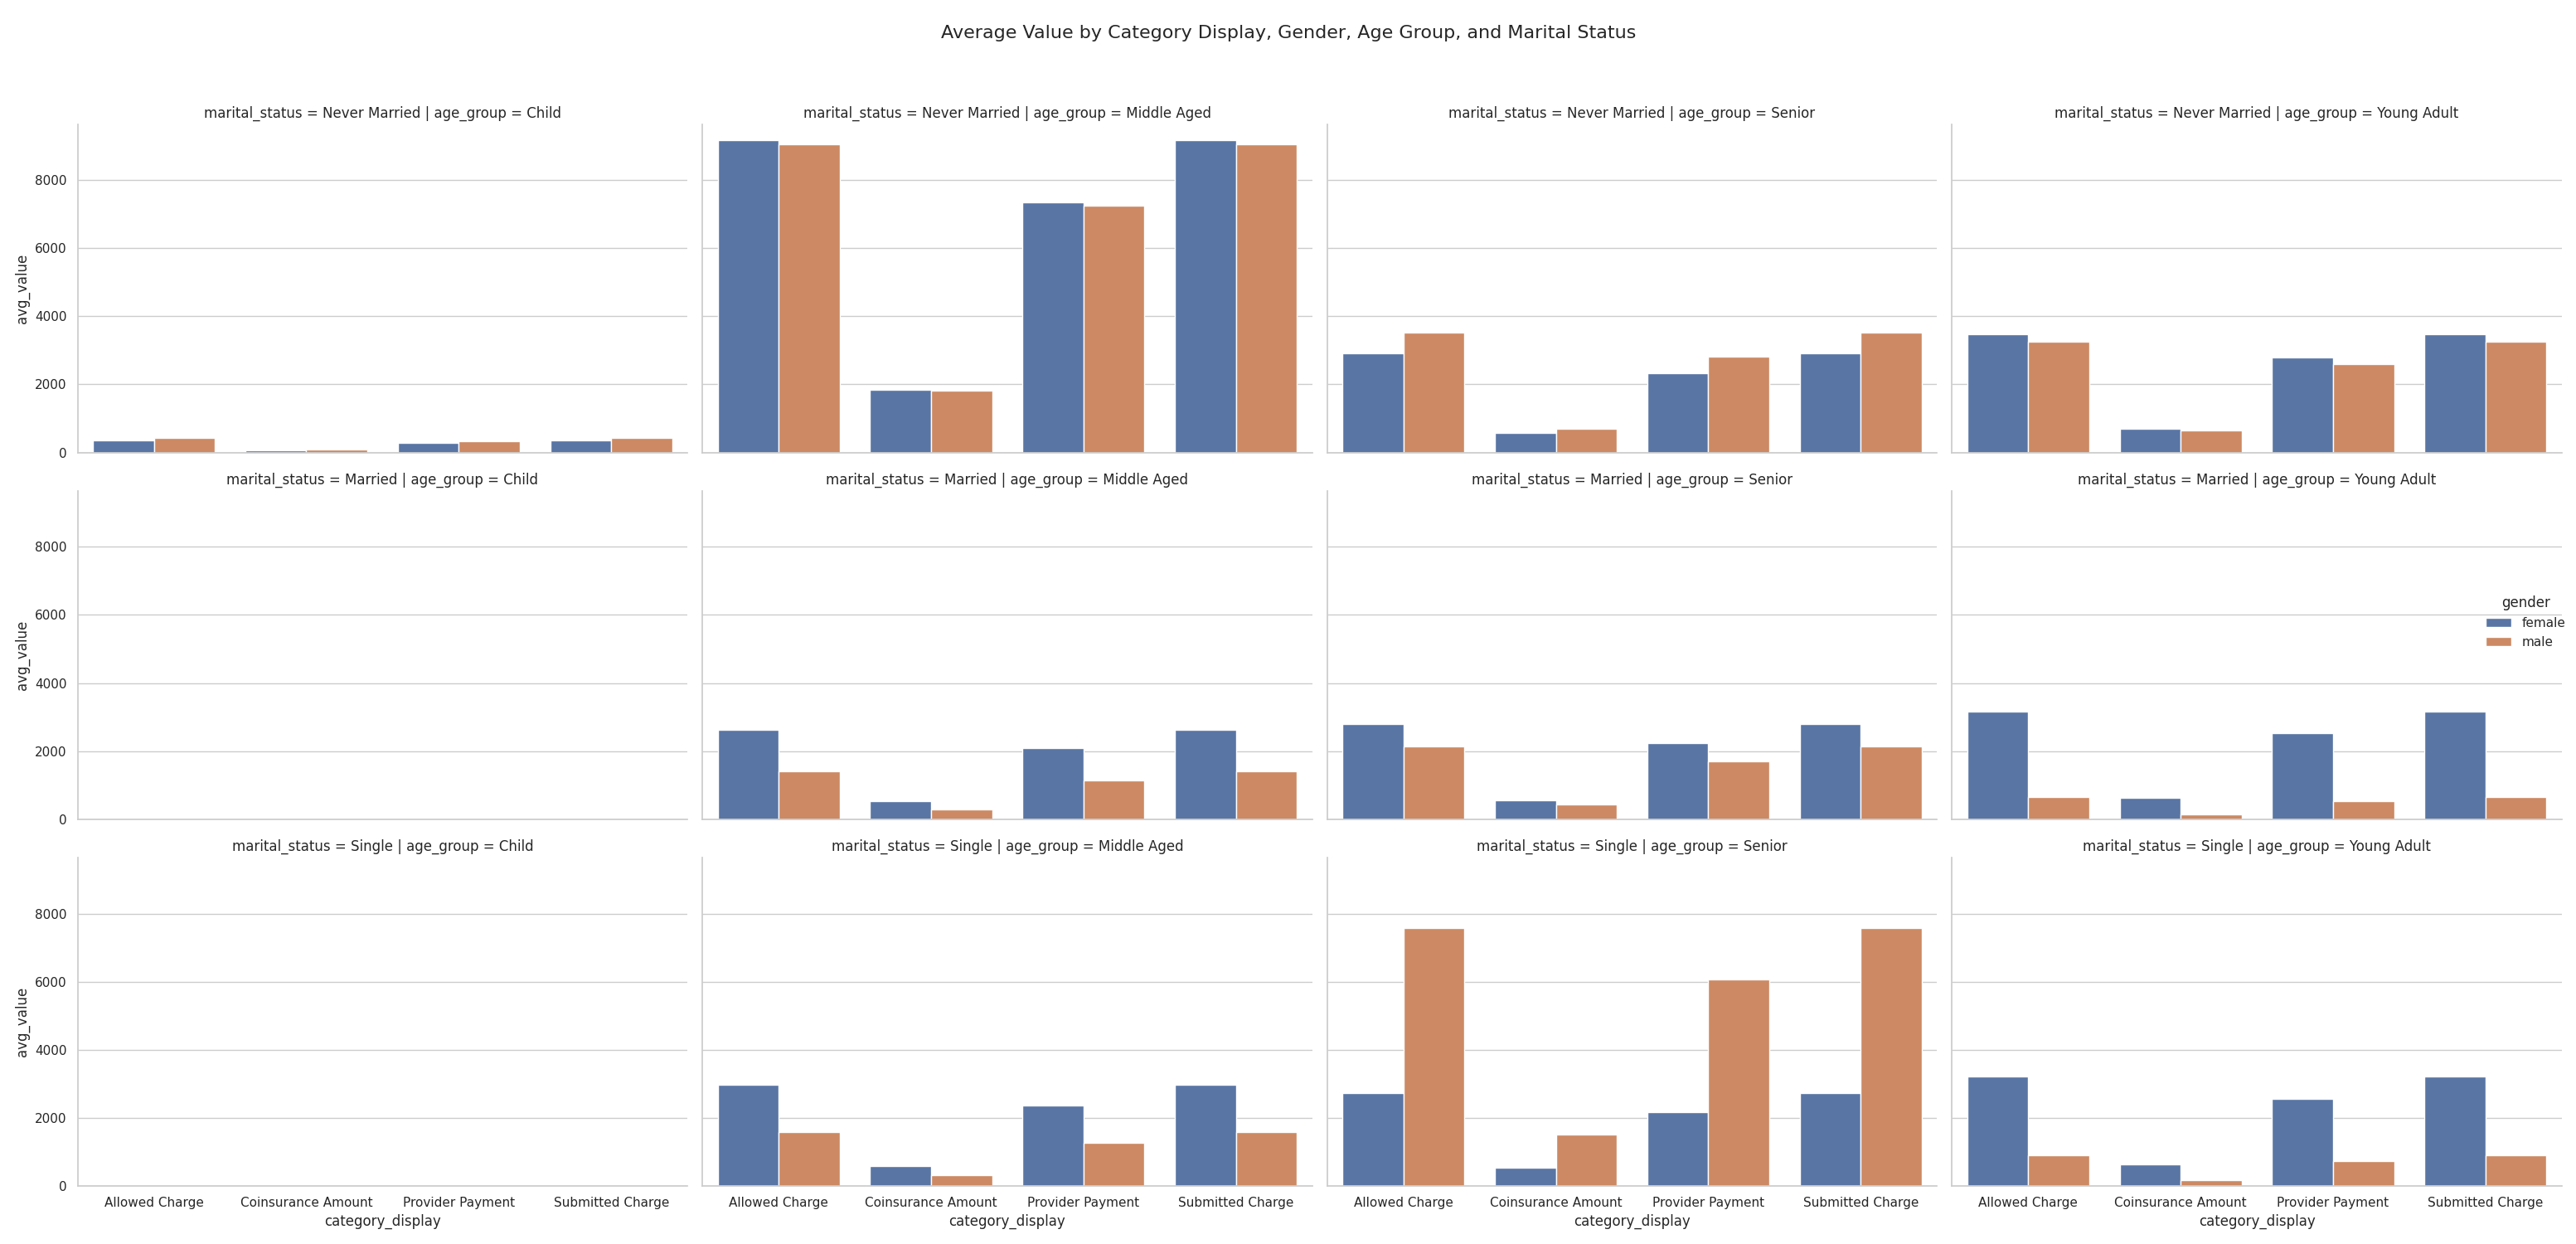

In [ ]:
pivoted_data = category_gender_age_group_marital_avg_value.pivot_table(
    values="avg_value", 
    index=["gender", "age_group", "marital_status"], 
    columns="category_display"
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivoted_data, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Average Value by Gender, Age Group, Marital Status, and Category Display")
plt.xlabel("Category Display")
plt.ylabel("Gender, Age Group, Marital Status")
plt.tight_layout()
plt.show()
upload_plot_to_s3(plt, "AverageValuebyCategoryDisplayandAgeGroupHeatmap")

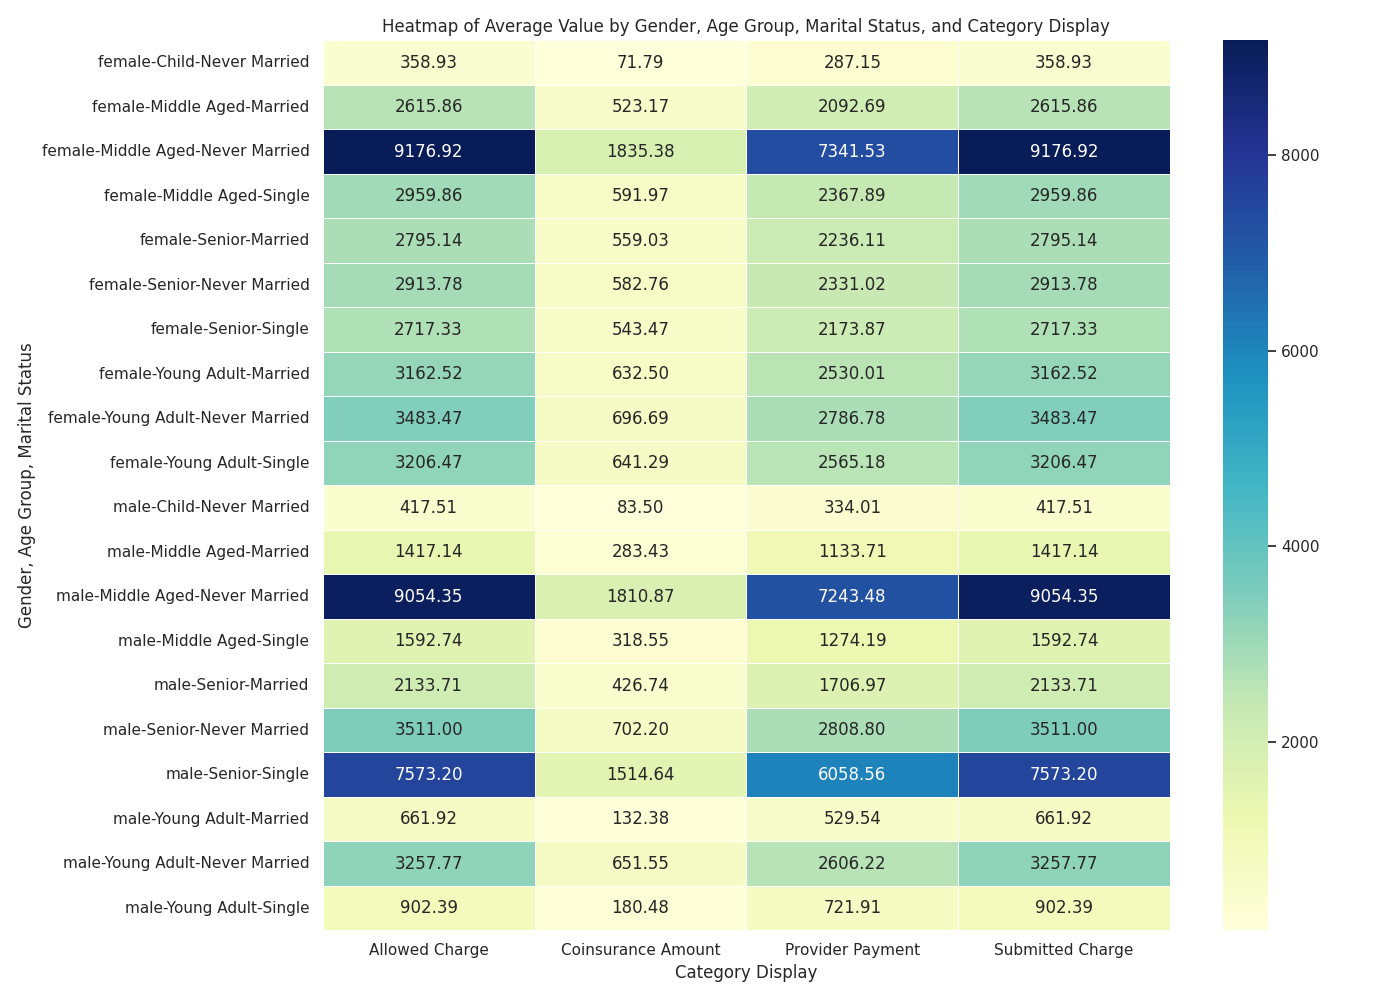